In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!uv add scipy
#!uv add matplotlib
#!uv add rich
#!uv add pvporcupine

In [3]:
import os
from rich import print

In [4]:
import pyaudio
print(pyaudio.__version__)

0.2.14

In [5]:
import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

print(sd.query_devices())

0 bcm2835 Headphones: - (hw:0,0), ALSA (0 in, 8 out)
   1 seeed-2mic-voicecard: bcm2835-i2s-wm8960-hifi wm8960-hifi-0 (hw:2,0), ALSA (2 in, 2 out)
   2 sysdefault, ALSA (0 in, 128 out)
   3 lavrate, ALSA (0 in, 128 out)
   4 samplerate, ALSA (0 in, 128 out)
   5 speexrate, ALSA (0 in, 128 out)
   6 speex, ALSA (0 in, 1 out)
   7 upmix, ALSA (0 in, 8 out)
   8 vdownmix, ALSA (0 in, 6 out)
   9 playback, ALSA (0 in, 128 out)
  10 capture, ALSA (128 in, 0 out)
  11 dmixed, ALSA (0 in, 2 out)
  12 array, ALSA (2 in, 0 out)
  13 dmix, ALSA (0 in, 2 out)
* 14 default, ALSA (128 in, 128 out)

In [6]:
PICOVOICE_API_KEY=os.environ['PICOVOICE_API_KEY']
OPENAI_API_KEY=os.environ['OPENAI_API_KEY']

In [7]:
DEVICE = "seeed-2mic-voicecard"
audio_file = "output_3.wav"

In [8]:
# Record 5 seconds of audio
duration = 5  
samplerate = 48000  # matches openWakeWord default
recording = sd.rec(int(duration * samplerate), 
                   samplerate=samplerate, 
                   channels=1, 
                   dtype='int16', 
                   device=DEVICE)
sd.wait()

print("Recorded shape:", recording.shape)

Recorded shape:
(240000, 1)

In [9]:
# Play back the recorded audio
sd.play(recording, samplerate=samplerate, device=DEVICE)
sd.wait()
write(audio_file,samplerate, recording)
print(f"Saved as {audio_file}")

Saved as output_3.wav

In [10]:
!ls -lah

total 2.4M
drwxr-xr-x 3 rsilveira79 rsilveira79 4.0K Sep  6 13:22 .
drwxr-xr-x 6 rsilveira79 rsilveira79 4.0K Sep  6 12:27 ..
-rw-r--r-- 1 rsilveira79 rsilveira79  29K Sep  6 13:22 0.test_audio.ipynb
drwxr-xr-x 2 rsilveira79 rsilveira79 4.0K Sep  5 16:56 .ipynb_checkpoints
-rw-r--r-- 1 rsilveira79 rsilveira79 938K Sep  5 17:12 output_2.wav
-rw-r--r-- 1 rsilveira79 rsilveira79 469K Sep  6 13:22 output_3.wav
-rw-r--r-- 1 rsilveira79 rsilveira79 938K Sep  5 17:10 output.wav


In [11]:
## Plot audio 

In [12]:
audio_data = recording.flatten()
time = np.arange(audio_data.shape[0]) / samplerate

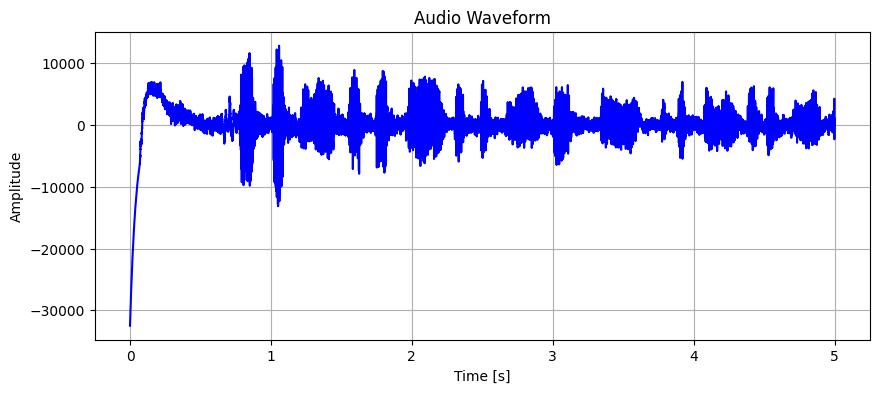

In [13]:
# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(time, audio_data, color='blue')
plt.title("Audio Waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## RGB LEDs

In [ ]:
import spidev
import time

In [ ]:
spidev.__version__

In [ ]:
spi = spidev.SpiDev()

In [ ]:
spi = spidev.SpiDev()
spi.open(0, 0)
spi.max_speed_hz = 8000000

In [ ]:
BRIGHTNESS_LEVELS = {
    "off": 0,
    "very-low": 5,
    "low": 5,
    "mid": 15,
    "mid-high": 20,
    "full": 31
}

COLORS = {
    "blue": [255, 0, 0],
    "light_blue": [230, 216, 173],
    "magenta": [255, 0, 255],
    "yellow": [0, 255, 255],
    "green": [0, 255, 0],
    "light_green": [144, 238, 144],
    "orange": [0, 165, 255],
    "red": [0, 0, 255]
}

In [ ]:
def set_led_color(color: dict, brightness_mode: dict):
    '''
    Following APA102 SPI Protocol
    # Start Frame: [0x00, 0x00, 0x00, 0x00]
    # Format: [brightness, Blue, Green, Red]
    # Brightness: 0b111xxxxx (0–31)
    # End Frame: [0xFF, 0xFF, 0xFF, 0xFF]
    '''
    data = []
    data += [0x00, 0x00, 0x00, 0x00]
    brightness = [0b11100000 | brightness_mode]
    for _ in range(3):  # 3 LEDs on the HAT
        data += brightness + color
    data += [0xFF, 0xFF, 0xFF, 0xFF]
    spi.xfer2(data)

In [ ]:
def breathe_color(color_name, cycles=3, step_delay=0.05, max_brightness:int = 31):
    color = COLORS[color_name]
    # Smooth brightness ramp up and down
    brightness_values = list(range(0, max_brightness+1, 1)) + list(range(max_brightness, -1, -1))
    for _ in range(cycles):
        for b in brightness_values:
            set_led_color(color, b)
            time.sleep(step_delay)

In [ ]:
breathe_color("magenta", cycles=10, step_delay=0.03)

In [ ]:
breathe_color("magenta", cycles=3, step_delay=0.03, max_brightness=30)

In [ ]:
set_led_color(COLORS['magenta'], BRIGHTNESS_LEVELS['mid'])

In [ ]:
set_led_color(COLORS['magenta'], BRIGHTNESS_LEVELS['full'])

In [ ]:
set_led_color(COLORS['yellow'], BRIGHTNESS_LEVELS['low'])

In [ ]:
set_led_color(COLORS['magenta'], BRIGHTNESS_LEVELS['off'])

In [ ]:
data = []
data += [0x00, 0x00, 0x00, 0x00]
brightness = [0b11100000 | BRIGHTNESS_LEVELS['low']]
data += brightness + COLORS['red']
data += brightness + COLORS['magenta']
data += brightness + COLORS['yellow']
data += [0xFF, 0xFF, 0xFF, 0xFF]
print(f"LED Colors: {data}")
spi.xfer2(data)

In [ ]:
# --- Rainbow colors in RGB ---
RAINBOW_COLORS = [
    (255, 0, 0),       # Red
    (255, 165, 0),     # Orange
    (255, 255, 0),     # Yellow
    (0, 255, 0),       # Green
    (0, 255, 255),     # Cyan
    (0, 0, 255),       # Blue
    (128, 0, 128)      # Purple
]

NUM_LEDS = 3

# --- Function to send LED data ---
def write_leds(colors, brightness):
    """
    colors: list of RGB tuples, one for each LED
    brightness: 0-31
    """
    data = [0x00, 0x00, 0x00, 0x00]  # Start frame
    led_brightness = 0b11100000 | brightness
    for r, g, b in colors:
        data += [led_brightness, b, g, r]  # APA102 = BGR
    data += [0xFF, 0xFF, 0xFF, 0xFF]  # End frame
    spi.xfer2(data)

# --- Breathing brightness ramp ---
def brightness_ramp():
    # Smooth ramp up and down
    return list(range(0, 20)) + list(range(20, -1, -1))

# --- Rotating rainbow with breathing ---
def rotating_rainbow_breathe(cycles=5, step_delay=0.03):
    colors = RAINBOW_COLORS.copy()
    for _ in range(cycles):
        for b in brightness_ramp():
            # Pick the first 3 colors for LEDs
            led_colors = [colors[i % len(colors)] for i in range(NUM_LEDS)]
            write_leds(led_colors, b)
            time.sleep(step_delay)
            # Rotate colors for next step
            colors = colors[1:] + colors[:1]

In [ ]:
rotating_rainbow_breathe(cycles=10, step_delay=0.2)

## Wakeup word

In [14]:
import pvporcupine
import pyaudio
import struct
print(pvporcupine.KEYWORDS)

porcupine = pvporcupine.create(access_key=PICOVOICE_API_KEY,
                               keywords=['porcupine'])
pa = pyaudio.PyAudio()

{
    'alexa',
    'americano',
    'ok google',
    'grasshopper',
    'bumblebee',
    'grapefruit',
    'hey google',
    'terminator',
    'picovoice',
    'porcupine',
    'jarvis',
    'pico clock',
    'blueberry',
    'computer',
    'hey siri',
    'hey barista'
}

In [ ]:
volume = 0.3
data = data * volume

In [3]:
data

NameError: name 'data' is not defined

In [1]:
def play_sound(file: str):
    import sounddevice as sd
    from scipy.io import wavfile

    samplerate, data = wavfile.read(file)
    sd.play(data, samplerate)
    sd.wait()

In [16]:
!ls -lah ../audio/

total 936K
drwxr-xr-x 2 rsilveira79 rsilveira79 4.0K Sep  6 12:36 .
drwxr-xr-x 6 rsilveira79 rsilveira79 4.0K Sep  6 12:27 ..
-rw-r--r-- 1 rsilveira79 rsilveira79 467K Sep  6 12:26 ding_elegant.wav
-rw-r--r-- 1 rsilveira79 rsilveira79 101K Sep  6 11:06 fart.wav
-rw-r--r-- 1 rsilveira79 rsilveira79 355K Sep  6 12:36 star_ding.wav


In [17]:
play_sound("../audio/fart.wav")

In [2]:
play_sound("../audio/ding_elegant.wav")

In [4]:
play_sound("../audio/star_ding.wav", volume=0.02)

/tmp/ipykernel_880/2116437497.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(file)


In [ ]:
!pwd

In [ ]:
stream = pa.open(
    rate=porcupine.sample_rate,
    channels=1,
    format=pyaudio.paInt16,
    input=True,
    frames_per_buffer=porcupine.frame_length
)

while True:
    pcm = stream.read(porcupine.frame_length, exception_on_overflow=False)
    pcm = struct.unpack_from("h" * porcupine.frame_length, pcm)
    result = porcupine.process(pcm)
    if result >= 0:
        print("Wake word detected!")
        play_sound("../audio/star_ding.wav")
        breathe_color("magenta", cycles=3, step_delay=0.03, max_brightness=30)

## Using AsyncIO

In [21]:
import asyncio
import nest_asyncio

nest_asyncio.apply()

In [22]:
stream = pa.open(
    rate=porcupine.sample_rate,
    channels=1,
    format=pyaudio.paInt16,
    input=True,
    frames_per_buffer=porcupine.frame_length
)

In [23]:
async def play_sound_async(path):
    loop = asyncio.get_running_loop()
    await loop.run_in_executor(None, play_sound, path)

In [24]:
async def breathe_color_async(color, cycles=3, step_delay=0.03, max_brightness=30):
    # If breathe_color is blocking, run it in a thread
    loop = asyncio.get_running_loop()
    await loop.run_in_executor(None, breathe_color, color, cycles, step_delay, max_brightness)

In [25]:
async def handle_wake_word():
    print("Wake word detected!")
    await asyncio.gather(
        play_sound_async("../audio/star_ding.wav"),
        breathe_color_async("magenta", cycles=3, step_delay=0.03, max_brightness=30)
    )

In [26]:
async def main_loop():
    while True:
        pcm = stream.read(porcupine.frame_length, exception_on_overflow=False)
        pcm = struct.unpack_from("h" * porcupine.frame_length, pcm)
        result = porcupine.process(pcm)
        if result >= 0:
            # Schedule action without blocking
            asyncio.create_task(handle_wake_word())

In [29]:
#asyncio.run(main_loop())